## PySpark Basics in CML

**Apache Spark is a general purpose framework for distributed computing that offers high performance for both batch and stream processing. It exposes APIs for Java, Python, R, and Scala, as well as an interactive shell for you to run jobs.**

**In Cloudera Machine Learning (CML), Spark and its dependencies are bundled directly into the CML engine Docker image or CML Runtime. CML supports fully-containerized execution of Spark workloads via Spark's support for the Kubernetes cluster backend. Users can interact with Spark both interactively and in batch mode.**

 

![title](img/sparkonk8s.png)

**The bottom line: Spark on CML is dramatically easier to use than Spark on Yarn on CDSW or other platforms. There is no need to distribute dependencies among execuotors. You can easily spin up multi-executor distributed Spark Sessions and interrupt them as needed, all within quotas and other cost monitoring constraints**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

**A simple, single pod Spark Session can be instantiated as shown below. This creates a single pod for the Spark application**

In [3]:
spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("SimpleSession")\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 00:37:38 WARN JettyUtils: GET /jobs/ failed: java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
java.util.NoSuchElementException: Failed to get the application information. If you are starting up Spark, please wait a while until it's ready.
	at org.apache.spark.status.AppStatusStore.applicationInfo(AppStatusStore.scala:51)
	at org.apache.spark.ui.jobs.AllJobsPage.render(AllJobsPage.scala:276)
	at org.apache.spark.ui.WebUI.$anonfun$attachPage$1(WebUI.scala:90)
	at org.apache.spark.ui.JettyUtils$$anon$1.doGet(JettyUtils.scala:81)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:687)
	at javax.servlet.http.HttpServlet.service(HttpServlet.java:790)
	at org.sparkproject.je

In [4]:
spark

In [5]:
import os
print("https://spark-"+os.environ["CDSW_ENGINE_ID"]+"."+os.environ["CDSW_DOMAIN"])

https://spark-ikgvjqk3qptnit2c.ml-d7f9c760-9de.go01-dem.ylcu-atmi.cloudera.site


You can reach the Spark UI from the URL as shown above.

![title](img/spark_ui.png)

You can stop the Spark session any time as below

Let's try a Spark Session with more horsepower. You can increase number of cores and memory for the Driver and Executors with the following settings

In [ ]:
"""spark = SparkSession\
    .builder\
    .master("local")\
    .appName("DistributedSession")\
    .config("spark.executor.memory","2g")\
    .config("spark.executor.cores","5")\
    .config("spark.driver.memory","2g")\
    .getOrCreate()"""

You just created a distributed Spark Session with 1 Driver and 5 Executors. Each Executor has 8 cores and 2GB of memory. Not bad!

In [6]:
spark.stop()

## Spark Data Connections

The best way to launch a spark session is however Spark Data Connections. This feature provides the code you need to launch your Spark Session and already includes the Iceberg jars to enable Lakehouse analytics!

To launch a Spark Data Connection, open "Data" and pick the "Spark" option. Then copy paste the code into the cell below:

![title](img/dataconnections.png)

In [9]:
import cml.data_v1 as cmldata

# Sample in-code customization of spark configurations
#from pyspark import SparkContext
#SparkContext.setSystemProperty('spark.executor.cores', '1')
#SparkContext.setSystemProperty('spark.executor.memory', '2g')

CONNECTION_NAME = "go01-aw-dl"
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

# Sample usage to run query through spark
EXAMPLE_SQL_QUERY = "show databases"
spark.sql(EXAMPLE_SQL_QUERY).show()

+--------------------+
|           namespace|
+--------------------+
|         01_car_data|
|           01_car_dw|
|              adb101|
|            airlines|
|        airlines_csv|
|    airlines_iceberg|
|airlines_iceberg_...|
|      airlines_maint|
|      airlines_mjain|
|          airquality|
|                ajvp|
|     akahan_airlines|
|           amallegni|
|          atlas_demo|
|            bankdemo|
|          bca_jps_l0|
|      bnk_mlops_demo|
|       bnk_mlops_hol|
|     bri_ranger_demo|
|            cdc_data|
+--------------------+
only showing top 20 rows



## Intro to Spark SQL

In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = spark.read.option("inferschema", True).option("header", True).csv('data/LoanStats_2015_subset.csv')

In [13]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(29796, 105)


In [14]:
#df.printSchema()

## KPI Reporting

In [15]:
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import Bucketizer

#### Min and Max Loan Amount 

In [16]:
print("Minimum Loan Amount")
df.agg(F.min("loan_amnt")).show()

print("Maximum Loan Amount")
df.agg(F.max("loan_amnt")).show()

Minimum Loan Amount
+--------------+
|min(loan_amnt)|
+--------------+
|          1000|
+--------------+

Maximum Loan Amount
+--------------+
|max(loan_amnt)|
+--------------+
|         35000|
+--------------+



#### Create Bins from the Loan Amount Column

In [17]:
df2 = Bucketizer(
    splits=[-float('inf'), 10000, 20000, float('inf')],
    inputCol='loan_amnt',
    outputCol='loan_amnt_bin'
).transform(df)

In [18]:
df2_pandas = df2.select("loan_amnt_bin").toPandas()
df2_pandas

,loan_amnt_bin
0,1.0
1,2.0
2,2.0
3,2.0
4,1.0
...,...
29791,2.0
29792,2.0
29793,2.0
29794,1.0


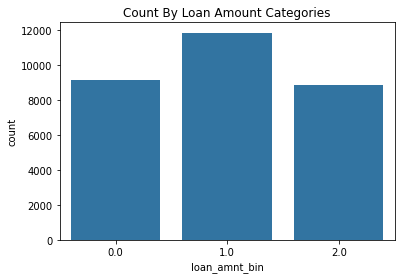

In [19]:
sns.countplot(x="loan_amnt_bin", data=df2_pandas).set(title='Count By Loan Amount Categories')
plt.show()

### Rounded Mean Funded Amount By Loan Amount Bins

In [20]:
#how many loans defaulted for each month (all data is 2015):
df2.groupby('loan_amnt_bin').mean('funded_amnt').na.drop().select("loan_amnt_bin", F.ceil(F.col("avg(funded_amnt)"))).show()

+-------------+----------------------+
|loan_amnt_bin|CEIL(avg(funded_amnt))|
+-------------+----------------------+
|          0.0|                  5823|
|          1.0|                 13751|
|          2.0|                 26144|
+-------------+----------------------+



### Spark SQL

In [21]:
spark.sql("show databases").show()

+--------------------+
|           namespace|
+--------------------+
|         01_car_data|
|           01_car_dw|
|              adb101|
|            airlines|
|        airlines_csv|
|    airlines_iceberg|
|airlines_iceberg_...|
|      airlines_maint|
|      airlines_mjain|
|          airquality|
|                ajvp|
|     akahan_airlines|
|           amallegni|
|          atlas_demo|
|            bankdemo|
|          bca_jps_l0|
|      bnk_mlops_demo|
|       bnk_mlops_hol|
|     bri_ranger_demo|
|            cdc_data|
+--------------------+
only showing top 20 rows



In [22]:
spark.sql("show tables").show()

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|gartner_florida_s...|      false|
|  default|                   t|      false|
|  default|                   s|      false|
|  default|        driver_stats|      false|
|  default|      shaun_ice_ty21|      false|
|  default|      hue__tmp_test2|      false|
|  default|        test_varchar|      false|
|  default|  churn_prototype_fh|      false|
|  default|churn_prototype_t...|      false|
|  default|           t2_impala|      false|
|  default|  test_varchar_parq2|      false|
|  default|      loan_prototype|      false|
|  default|        tax_auth_heb|      false|
|  default|                test|      false|
|  default|     results_anomaly|      false|
|  default|   churn_mengelhardt|      false|
|  default|             mytable|      false|
|  default|        transactions|      false|
|  default|               ice_t|      false|
|  default

#### Saving the Table As Temporary View

In [23]:
## Registering the dataframe as a temporary table:
## Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 

df2.createOrReplaceTempView("my_temp_view")

24/03/16 00:47:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### Saving the Table Permanently in CDW

In [24]:
## The table will now be a Hive External Table and will show in CDW and Atlas.
## Ranger Policies can now be set on the Table

df2.select(["funded_amnt", "loan_amnt", "installment", "tot_cur_bal"]).write.format('parquet').mode("overwrite").saveAsTable('default.my_hive_table')

24/03/16 00:48:20 WARN ShellBasedUnixGroupsMapping: unable to return groups for user pauldefusco
PartialGroupNameException The user name 'pauldefusco' is not found. id: ‘pauldefusco’: no such user
id: ‘pauldefusco’: no such user

	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.resolvePartialGroupNames(ShellBasedUnixGroupsMapping.java:291)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getUnixGroups(ShellBasedUnixGroupsMapping.java:215)
	at org.apache.hadoop.security.ShellBasedUnixGroupsMapping.getGroupsSet(ShellBasedUnixGroupsMapping.java:123)
	at org.apache.hadoop.security.Groups$GroupCacheLoader.fetchGroupSet(Groups.java:413)
	at org.apache.hadoop.security.Groups$GroupCacheLoader.load(Groups.java:351)
	at org.apache.hadoop.security.Groups$GroupCacheLoader.load(Groups.java:300)
	at com.google.common.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3529)
	at com.google.common.cache.LocalCache$Segment.loadSync(LocalCache.java:2278)
	at com.google.

In [25]:
spark.stop()